In [2]:
#Import Libraries/Packages
#import numpy as np 
import cv2  ##pip install opencv-python
import os   
import random
from skimage.io import imread
#import pandas as pd
import seaborn as sns
import tensorflow as tf ##pip install tensorflow-gpu
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, BatchNormalization, Conv2D,MaxPooling2D,Activation
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt
from IPython.display import Audio

# loop through training photos

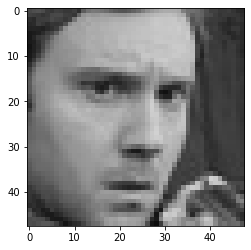

In [6]:
Datadirectory = "images/train/"
#classes= ['angry','disgust','fear','happy','neutral','sad','surprise']
classes= ['0','1','2','3','4','5','6']
for category in classes:
    path=os.path.join(Datadirectory,category)
    for img in os.listdir(path):
        img_array=cv2.imread(os.path.join(path,img))
        plt.imshow(cv2.cvtColor(img_array,cv2.COLOR_BGR2RGB))
        plt.show()
        break#break to just show the first photo in first folder
    break    

# loop through testing photos

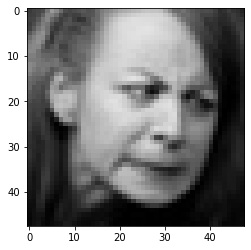

In [57]:
validDirectory="images/validation/"
#classes= ['angry','disgust','fear','happy','neutral','sad','surprise']
classes= ['0','1','2','3','4','5','6']
for category in classes:
    path=os.path.join(validDirectory,category)
    for img in os.listdir(path):
        img_array=cv2.imread(os.path.join(path,img))
        plt.imshow(cv2.cvtColor(img_array,cv2.COLOR_BGR2RGB))
        plt.show()
        break#break to just show the first photo in first folder
    break    

## Read All images and convert it into array

In [58]:
training_Data=[]
def create_training_Data():
    for category in classes:
        path=os.path.join(Datadirectory,category)
        class_num =classes.index(category) # 0 1 # the class name is my label
        for img in os.listdir(path):
            try:
                img_array=cv2.imread(os.path.join(path,img))
                #new_array = cv2.resize(img_array, (img_size,img_size))
                # the array has two values (info of image , emotion which is the class angry orsad)
                training_Data.append([img_array, class_num]) 
            except Exception as e:
                pass

In [59]:
create_training_Data()

In [60]:
validation_Data=[]
validDirectory="images/validation/"
def create_validation_Data():
    for category in classes:
        path=os.path.join(validDirectory,category)
        class_num =classes.index(category) # 0 1 # the class name is my label
        for img in os.listdir(path):
            try:
                img_array=cv2.imread(os.path.join(path,img))
                #new_array = cv2.resize(img_array, (img_size,img_size))
                # the array has two values (info of image , emotion which is the class angry orsad)
                validation_Data.append([img_array, class_num]) 
            except Exception as e:
                pass

In [61]:
create_validation_Data()

##  will shuffle the data so the deep learning will not know the sequence

In [62]:
import random
# will shuffle the data so the deep learning will not know the sequence to prevent overfitting
random.shuffle(training_Data)
random.shuffle(validation_Data)

# Storing the features in x and labels in y

In [63]:
x_train = [] # features
y_train= [] #labels
# as in training_Data is stored as (info of image , emotion which is the class angry or sad which is numbers from 0 to 6)
for features, labels in (training_Data):
    x_train.append(features)
    y_train.append(labels)
    
x_test = [] # features
y_test= [] #labels

for features, labels in (validation_Data):
    x_test.append(features)
    y_test.append(labels)    

## Data Visualization

C:\Users\Habiba\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:ylabel='count'>

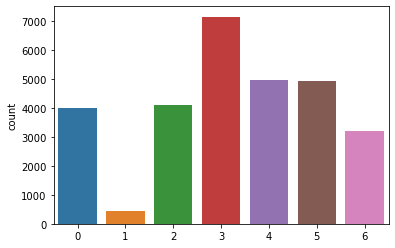

In [66]:
import seaborn as sns
sns.countplot(y_train)
#sns.countplot(y_test)


# Reset the dimensions of photos

In [67]:
train_dir='images/train/'
happy = os.listdir(train_dir+'3/')
dim1, dim2 = [], []

for img_filename in happy:
    img = imread(train_dir+'3/'+img_filename)
    d1, d2 = img.shape
    dim1.append(d1)
    dim2.append(d2)

img_shape = (int(np.mean(dim1)), int(np.mean(dim2)), 1)
#sns.jointplot(dim1, dim2,color='g')
#plt.show()

 # Initialize image data generator with rescaling

In [42]:
train_gen = ImageDataGenerator(rescale=1/255,
                                rotation_range=40,
                                width_shift_range=0.2,
                                height_shift_range=0.2,
                                shear_range=0.2,
                                zoom_range=0.2,
                                horizontal_flip=True,
                                fill_mode='nearest')

test_gen = ImageDataGenerator(rescale=1/255)

img_shape = (int(np.mean(dim1)), int(np.mean(dim2)), 1)

## Preprocess all test images and train images

In [68]:
# Data Preprocessing

test_dir ='images/validation/'
train_generator = train_gen.flow_from_directory(directory=train_dir,
                                                target_size=(img_shape[0], img_shape[1]),
                                                color_mode='grayscale',
                                                batch_size=64,
                                                class_mode='categorical',
                                                shuffle=True)

test_generator = test_gen.flow_from_directory(directory=test_dir,
                                               target_size=(img_shape[0], img_shape[1]),
                                                color_mode='grayscale',
                                                batch_size=64,
                                                class_mode='categorical',
                                                shuffle=False)

Found 28821 images belonging to 7 classes.
Found 7066 images belonging to 7 classes.


#  Create model structure

In [69]:
# Create the Model
model = Sequential()

model.add(Conv2D(filters=64, kernel_size=(3,3), padding='same', activation='relu', input_shape=img_shape))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.2))

model.add(Conv2D(filters=128, kernel_size=(3,3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.2))

model.add(Conv2D(filters=512, kernel_size=(3,3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.2))

model.add(Conv2D(filters=512, kernel_size=(3,3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.2))
#before doing the dense layer we have to flatten bsc. convolution is 2d while dense layer is 1D
model.add(Flatten())

model.add(Dense(512, activation='relu'))
model.add(Dropout(0.2))

model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.2))

model.add(Dense(units=len(os.listdir(train_dir)), activation='softmax'))

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 48, 48, 64)        640       
                                                                 
 batch_normalization_4 (Batc  (None, 48, 48, 64)       256       
 hNormalization)                                                 
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 24, 24, 64)       0         
 2D)                                                             
                                                                 
 dropout_6 (Dropout)         (None, 24, 24, 64)        0         
                                                                 
 conv2d_5 (Conv2D)           (None, 24, 24, 128)       73856     
                                                                 
 batch_normalization_5 (Batc  (None, 24, 24, 128)     

In [70]:
# Train the model
model.compile(optimizer=Adam(learning_rate=0.0001, 
                             decay=1e-6), 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

# Train the neural network/model

In [137]:
steps_per_epoch = train_generator.n // train_generator.batch_size
validation_steps = test_generator.n // test_generator.batch_size
num_epochs = 30

history = model.fit(train_generator,
                    epochs=num_epochs,
                    verbose=1,
                    #callbacks=callbacks,
                    validation_data=test_generator,
                    steps_per_epoch=steps_per_epoch,
                    validation_steps=validation_steps)

Epoch 1/30
450/450 [==============================] - 281s 623ms/step - loss: 1.5853 - accuracy: 0.3760 - val_loss: 1.5114 - val_accuracy: 0.4080
Epoch 2/30
450/450 [==============================] - 290s 644ms/step - loss: 1.5466 - accuracy: 0.3927 - val_loss: 1.3550 - val_accuracy: 0.4794
Epoch 3/30
450/450 [==============================] - 266s 591ms/step - loss: 1.5179 - accuracy: 0.4062 - val_loss: 1.4916 - val_accuracy: 0.4101
Epoch 4/30
450/450 [==============================] - 258s 572ms/step - loss: 1.4862 - accuracy: 0.4248 - val_loss: 1.3827 - val_accuracy: 0.4602
Epoch 5/30
450/450 [==============================] - 250s 556ms/step - loss: 1.4632 - accuracy: 0.4355 - val_loss: 1.3036 - val_accuracy: 0.5013
Epoch 6/30
450/450 [==============================] - 361s 804ms/step - loss: 1.4343 - accuracy: 0.4460 - val_loss: 1.2630 - val_accuracy: 0.5180
Epoch 7/30
450/450 [==============================] - 592s 1s/step - loss: 1.4178 - accuracy: 0.4525 - val_loss: 1.2597 - va

In [138]:
model.save("model.h5")

In [139]:
# Evaluate the model
test_loss, test_acc = model.evaluate(test_generator)
print("validation accuracy :", str(test_acc*100)+"%")
print("validation loss :", test_loss)

111/111 [==============================] - 11s 100ms/step - loss: 1.0582 - accuracy: 0.5978
validation accuracy : 59.779226779937744%
validation loss : 1.058190107345581


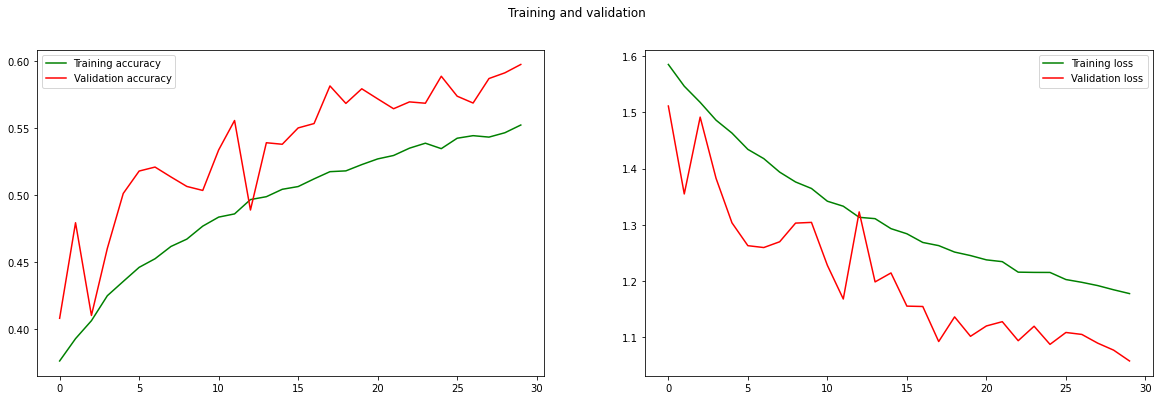

In [140]:

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(acc))

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(20, 6))
ax[0].plot(epochs, acc, 'g', label='Training accuracy')
ax[0].plot(epochs, val_acc, 'r', label='Validation accuracy')
ax[0].legend(loc=0)
ax[1].plot(epochs, loss, 'g', label='Training loss')
ax[1].plot(epochs, val_loss, 'r', label='Validation loss')
ax[1].legend(loc=0)

plt.suptitle('Training and validation')
plt.show()


111/111 [==============================] - 12s 106ms/step
              precision    recall  f1-score   support

           0       0.49      0.42      0.45       960
           1       0.49      0.25      0.33       111
           2       0.54      0.25      0.34      1018
           3       0.81      0.85      0.83      1825
           4       0.46      0.75      0.57      1216
           5       0.48      0.41      0.44      1139
           6       0.73      0.74      0.73       797

    accuracy                           0.60      7066
   macro avg       0.57      0.53      0.53      7066
weighted avg       0.60      0.60      0.58      7066





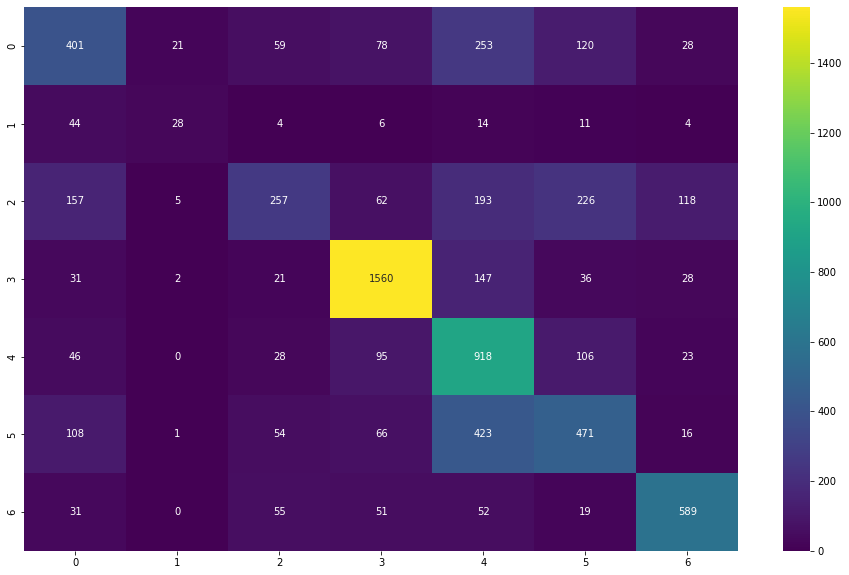

In [141]:
#heatmap visualization
from sklearn.metrics import classification_report, confusion_matrix

y_pred = np.argmax(model.predict(test_generator), axis=-1)
print(classification_report(test_generator.classes, y_pred, target_names=test_generator.class_indices.keys()), end='\n\n\n')

cm = confusion_matrix(test_generator.classes, y_pred)
plt.figure(figsize=(16,10))
sns.heatmap(cm, cmap=plt.cm.viridis, annot=True, fmt='.0f', xticklabels=test_generator.class_indices.keys(), yticklabels=test_generator.class_indices.keys())
plt.show()

 # Testing our model with new image

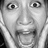

In [166]:
image = cv2.imread("fear.jpg")
from IPython.display import Image
Image(filename="fear.jpg")

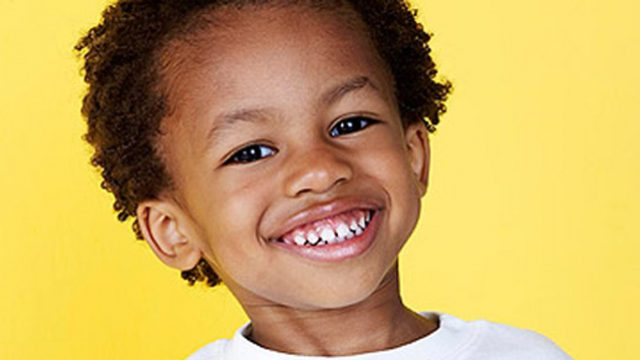

In [3]:
image = cv2.imread("Happychild.jpg")
from IPython.display import Image
Image(filename="Happychild.jpg")

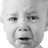

In [211]:
image = cv2.imread("sad.jpg")
from IPython.display import Image
Image(filename="sad.jpg")

# load the trained model

In [215]:

from tensorflow.python.keras.models import load_model



# # load the trained model

model = tf.keras.models.load_model("model.h5",
    custom_objects={'Functional':tf.keras.models.Model})
# A list of emoticon categories
EMOTIONS = ['Angry','Disgust','Fear','Happy','Neutral','Sad','Surprise']
# Load image
img = image

# Trim the image to 48 x 48, and turn the grayscale image, normalization
frame = cv2.resize(img,(48,48),interpolation=cv2.INTER_BITS2)
gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY) / 255.0

# Reinvent the image dimension
gray = gray.reshape(1,48,48,1)

# Output the prediction
predicts = model.predict(gray)[0]
print(predicts.argmax())

label = EMOTIONS[predicts.argmax()]
print( "\n\n The system considers this expression to be:",label)

1/1 [==============================] - 1s 686ms/step
4


 The system considers this expression to be: Neutral


In [216]:

if (label=='Happy' or label =='Surprise' ):
    path="audio/happy/"
    files=os.listdir(path)
    d=random.choice(files)
    print("Now Playing:",d)
    audio = Audio(filename='audio/happy/'+d,autoplay=True)   
    display(audio)


elif (label=='Angry'or label == 'Disgust' or label =='Fear'):  
    audio = Audio(filename='audio/fear/fear.mp3',autoplay=True)   
    display(audio)
    

    
elif (label=='Sad'):
    path="audio/sad/"
    files=os.listdir(path)
    d=random.choice(files)
    print("Now Playing:",d)
    audio = Audio(filename='audio/sad/'+d,autoplay=True)   
    display(audio)  
    

elif (label=='Neutral'):
    path="audio/neutral/"
    files=os.listdir(path)
    d=random.choice(files)
    print("Now Playing:",d)
    audio = Audio(filename='audio/neutral/'+d,autoplay=True)   
    display(audio)
    
    


Now Playing: Taylor Swift – august (Official Lyric Video).mp3


### Our Model has been successfully created 

# Thank you !